### AutoML test 02: using Optuna library on my GraphAutoencoder model with 2 LAYERS

Output: 

 - For dynamic: **node_embeddings_D_AutoML-2relu**
 
 - For static: **node_embeddings_S_AutoML-2relu.csv**

In [ ]:
# !pip install fastdtw
# !pip install plotly

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import optuna
import pandas as pd
import numpy as np
import torch.nn as nn
import os

from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GATConv

In [2]:
## Graph SAGE

torch.backends.cudnn.benchmark = True  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Defining Graph Autoencoder
class GSAGEEncoder(torch.nn.Module): 
    def __init__(self, input_dim, hidden_dim, out_dim, activation="relu"): 
        #torch.random.manual_seed(37) 
        super(GSAGEEncoder, self).__init__() 
        self.conv1 = SAGEConv(input_dim, hidden_dim)    # SAGEConv   # I removed cached=True of each layer
        self.conv2 = SAGEConv(hidden_dim, out_dim)     # SAGEConv
        
        if activation.lower() == "prelu":
            self.prelu = nn.PReLU()
            self.activation = self.prelu
        else:
            self.activation = self._get_activation(activation)  # Activation function 
        
    def _get_activation(self, name):
        activations = {
            "relu": F.relu,
            "leaky_relu": lambda x: F.leaky_relu(x, negative_slope=0.01),
            "tanh": torch.tanh,
            "selu": F.selu,
            "gelu": F.gelu,
            "swish": lambda x: x * torch.sigmoid(x),
            "none": lambda x: x  # Without activation
        }
        return activations.get(name.lower(), F.relu)  # Default: ReLU
    
    def forward(self, x, edge_index):
        #x = self.conv1(x, edge_index)  # borra esto para recuperar
        # Commentado 1 layer
        x = self.activation(self.conv1(x, edge_index))  # 1st layer
        x = self.conv2(x, edge_index)                   # 2nd layer
        return x

class GSAGEDecoder(torch.nn.Module):
    def __init__(self, in_features, hidden_dim, out_features, activation="relu"):
        super(GSAGEDecoder, self).__init__() 
        self.deconv1 = SAGEConv(in_features, hidden_dim)      # SAGEConv
        self.deconv2 = SAGEConv(hidden_dim, out_features)     # SAGEConv
        
        if activation.lower() == "prelu":
            self.prelu = nn.PReLU()
            self.activation = self.prelu
        else:
            self.activation = self._get_activation(activation) # Same function as the encoder
        
    def _get_activation(self, name):
        activations = {
            "relu": F.relu,
            "leaky_relu": lambda x: F.leaky_relu(x, negative_slope=0.01),
            "tanh": torch.tanh,
            "selu": F.selu,
            "gelu": F.gelu,
            "swish": lambda x: x * torch.sigmoid(x),
            "none": lambda x: x  # Without activation
        }
        return activations.get(name.lower(), F.relu)  # Default: ReLU
        
    def forward(self, x, edge_index):
        x = self.activation(self.deconv1(x, edge_index))  # 1st layer  
        x = self.deconv2(x, edge_index)                   # 2nd layer
        return x
    

class GraphAutoencoderSAGE(torch.nn.Module): 
    def __init__(self, input_dim, hidden_dim, latent_dim, activation="relu"):
        super(GraphAutoencoderSAGE, self).__init__() 
        self.encoder = GSAGEEncoder(input_dim, hidden_dim, latent_dim, activation)    
        # desCommenta para 2 layer
        self.decoder = GSAGEDecoder(latent_dim, hidden_dim, input_dim, activation)     # activame para 2 layers
        #self.decoder = GSAGEDecoder(hidden_dim, input_dim, latent_dim,  activation)   # activame para 1 layers
        
    def forward(self, x, edge_index):
        encoded = self.encoder(x, edge_index) 
        decoded = self.decoder(encoded, edge_index) 
        return decoded, encoded


Using device: cuda


In [3]:
### Graph Attention
torch.backends.cudnn.benchmark = True  # Al inicio del script
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Defining Graph Autoencoder
class GATEncoder(torch.nn.Module): 
    def __init__(self, input_dim, hidden_dim, out_dim, activation="relu"): 
        #torch.random.manual_seed(37) 
        super(GATEncoder, self).__init__() 
        self.conv1 = GATConv(input_dim, hidden_dim)    # SAGEConv   # I removed cached=True of each layer
        self.conv2 = GATConv(hidden_dim, out_dim)     # SAGEConv
        
        if activation.lower() == "prelu":
            self.prelu = nn.PReLU()
            self.activation = self.prelu
        else:
            self.activation = self._get_activation(activation)  # Activation function 
        
    def _get_activation(self, name):
        activations = {
            "relu": F.relu,
            "leaky_relu": lambda x: F.leaky_relu(x, negative_slope=0.01),
            "tanh": torch.tanh,
            "selu": F.selu,
            "gelu": F.gelu,
            "swish": lambda x: x * torch.sigmoid(x),
            "none": lambda x: x  # Sin activación
        }
        return activations.get(name.lower(), F.relu)  # Default: ReLU
    
    def forward(self, x, edge_index):
        x = self.activation(self.conv1(x, edge_index))  # 1st layer
        x = self.conv2(x, edge_index)                   # 2nd layer
        return x

class GATDecoder(torch.nn.Module):
    def __init__(self, in_features, hidden_dim, out_features, activation="relu"):
        super(GATDecoder, self).__init__() 
        self.deconv1 = GATConv(in_features, hidden_dim)      # SAGEConv
        # desCommenta para 2 layers
        self.deconv2 = GATConv(hidden_dim, out_features)     # SAGEConv
        
        if activation.lower() == "prelu":
            self.prelu = nn.PReLU()
            self.activation = self.prelu
        else:
            self.activation = self._get_activation(activation) # Same function as the encoder
        
    def _get_activation(self, name):
        activations = {
            "relu": F.relu,
            "leaky_relu": lambda x: F.leaky_relu(x, negative_slope=0.01),
            "tanh": torch.tanh,
            "selu": F.selu,
            "gelu": F.gelu,
            "swish": lambda x: x * torch.sigmoid(x),
            "none": lambda x: x  # Without activation
        }
        return activations.get(name.lower(), F.relu)  # Default: ReLU
        
    def forward(self, x, edge_index):
        #x = self.deconv1(x, edge_index)   # borra esto para recuperar
        # Commentado 2 layer
        x = self.activation(self.deconv1(x, edge_index))  # 1st layer  
        x = self.deconv2(x, edge_index)                   # 2nd layer
        return x
    
class GraphAutoencoderGAT(torch.nn.Module): 
    def __init__(self, input_dim, hidden_dim, latent_dim, activation="relu"):
        super(GraphAutoencoderGAT, self).__init__() 
        self.encoder = GATEncoder(input_dim, hidden_dim, latent_dim, activation)    
        self.decoder = GATDecoder(latent_dim, hidden_dim, input_dim, activation)     # activame para 2 layers
        
    def forward(self, x, edge_index):
        encoded = self.encoder(x, edge_index) 
        decoded = self.decoder(encoded, edge_index) 
        return decoded, encoded

Using device: cuda


# Parameters

In [39]:
# Optimizer
loss_func = "MSE"  # "MSE" (Mean Square Error)   # "MAE" (Mean Absolute Error) #Huber
data_set = "real" # "real"  "artificial"
    
type_graph_conv = "SAGE"# "SAGE" (WORKS VERY GOOD FOR ARTIFICIAL) # GAT   

# Intervals of parameters for Dynamic data (input dim=144)
HIDDEN_DIM_RANGE = (64, 512)
LATENT_DIM_RANGE = (8, 16)
LR_RANGE = (1e-4, 1e-1)
WEIGHT_DECAY = (1e-6, 1e-3)
NUM_EPOCHS_RANGE = (200, 1000) #(5000, 5200)  
N_LAYERS = 2
ACTIVATION_OPTION = "relu"
TYPE_DATA = 'S'  

In [40]:
suffix = 'exp_smooth_static'
output_folder = f'{data_set}/{type_graph_conv}_{suffix}'
os.makedirs(output_folder, exist_ok=True)

# Reading original data

In [42]:

if(data_set =="artificial"):
    print("artificial data")
    name_file_dataset = os.path.join("../datasets", "artificial_data_12_clusters_full.csv")
else: # real dataset
    print("real data")
    name_file_dataset = "../datasets/datasubset_nodes_waqar.csv"

df_nodes = pd.read_csv(name_file_dataset) # orignal raw data
df_nodes

real data


,Nodo,2006.01,2006.02,2006.03,2006.04,2006.05,2006.06,2006.07,2006.08,2006.09,...,menores_de_18_anos_taxa,18_a_65_anos_taxa,maiores_de_65_anos_taxa,Pontos_de_onibus,Estacao_de_metro,Estacao_de_trem,Terminal_de_onibus,Favela_proxima,lat,long
0,573641,1,0,0,0,0,0,0,0,0,...,0.210939,0.631893,0.157168,0.0,1.0,3.0,1.0,0.0,-23.562991,-46.703965
1,573643,0,0,0,0,0,0,1,0,1,...,0.169365,0.648065,0.182571,0.0,3.0,3.0,1.0,0.0,-23.567465,-46.702229
2,573644,0,1,0,1,1,0,0,0,0,...,0.125065,0.742215,0.132719,0.0,3.0,3.0,1.0,0.0,-23.572962,-46.699235
3,582438,0,0,0,1,0,0,0,2,0,...,0.125109,0.723529,0.151361,0.0,2.0,2.0,3.0,0.0,-23.528187,-46.661920
4,582442,0,0,0,0,0,0,0,0,0,...,0.147651,0.691275,0.161074,0.0,0.0,2.0,4.0,0.0,-23.517308,-46.656944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,25798409,0,0,0,0,0,0,0,0,0,...,0.266357,0.652312,0.081330,0.0,0.0,4.0,2.0,1.0,-23.507885,-46.712039
14636,25870742,0,0,0,0,0,0,0,0,0,...,0.231285,0.676118,0.092597,0.0,0.0,1.0,2.0,0.0,-23.563471,-46.611300
14637,25871831,0,0,0,0,0,0,0,0,0,...,0.220503,0.686654,0.092843,0.0,3.0,4.0,5.0,0.0,-23.551894,-46.625727
14638,25875949,0,0,0,0,0,0,0,0,0,...,0.229763,0.672624,0.097612,0.0,1.0,3.0,5.0,1.0,-23.521011,-46.637123


#### Dataset management
✅ [Checked] Check 'Pontos_de_onibus' column, it looks like a column of zeros

### Slicing dyanmic data

In [43]:
dynamic_dt = df_nodes.iloc[:, 1:145] 
dynamic_dt

,2006.01,2006.02,2006.03,2006.04,2006.05,2006.06,2006.07,2006.08,2006.09,2006.10,...,2017.03,2017.04,2017.05,2017.06,2017.07,2017.08,2017.09,2017.10,2017.11,2017.12
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,0,1,0,1,1,0,0,0,0,1,...,0,1,0,0,0,1,0,0,1,0
3,0,0,0,1,0,0,0,2,0,0,...,2,2,1,0,0,2,0,1,5,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14636,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14637,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14638,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Normalizing Dynamic data

In [44]:
from statsmodels.tsa.api import SimpleExpSmoothing
dynamic_dt_smooth = dynamic_dt.apply(lambda x: SimpleExpSmoothing(x, initial_level = 0, initialization_method="known").fit(smoothing_level=0.005, optimized=False).fittedvalues, axis = 1)

In [45]:
dynamic_dt_smooth_log = np.log1p(np.array(dynamic_dt_smooth))


In [46]:
dynamic_dt_norm = pd.DataFrame(dynamic_dt_smooth_log)
dynamic_dt_norm

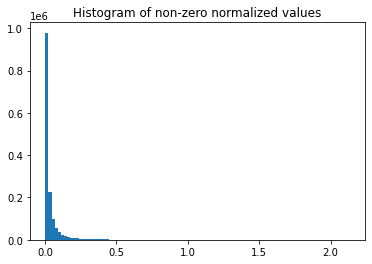

In [49]:
import matplotlib.pyplot as plt

plt.hist(np.array(dynamic_dt_norm)[np.array(dynamic_dt_norm) > 0].ravel(), bins=100)
plt.title("Histogram of non-zero normalized values")
plt.show()

In [83]:
from sklearn.preprocessing import MinMaxScaler
# Compute global min and max
global_min = dynamic_dt_smooth_log.min().min()
global_max = dynamic_dt_smooth_log.max().max()

# Apply global min-max normalization
dynamic_dt_norm = pd.DataFrame((dynamic_dt_smooth_log - global_min) / (global_max - global_min))
dynamic_dt_norm

,0,1,2,3,4,5,6,7,8,9,...,134,135,136,137,138,139,140,141,142,143
0,0.0,0.002336,0.002325,0.002313,0.002302,0.002290,0.002279,0.002267,0.002256,0.002245,...,0.111072,0.110577,0.110084,0.109594,0.109105,0.108618,0.108133,0.107650,0.107169,0.106689
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002336,0.002325,0.004638,...,0.073981,0.073638,0.073298,0.072958,0.072620,0.072284,0.071949,0.073621,0.073280,0.072941
2,0.0,0.000000,0.002336,0.002325,0.004638,0.006928,0.006894,0.006860,0.006826,0.006792,...,0.145653,0.145027,0.146120,0.145492,0.144867,0.144243,0.145343,0.144717,0.144094,0.145195
3,0.0,0.000000,0.000000,0.000000,0.002336,0.002325,0.002313,0.002302,0.006929,0.006894,...,0.088251,0.091716,0.095139,0.096618,0.096181,0.095746,0.099119,0.098672,0.100123,0.109044
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.008464,0.008422,0.008380,0.008339,0.008298,0.008256,0.008215,0.008175,0.008134,0.008094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14636,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14637,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14638,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


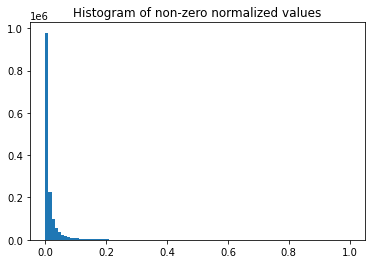

In [84]:
import matplotlib.pyplot as plt

plt.hist(np.array(dynamic_dt_norm)[np.array(dynamic_dt_norm) > 0].ravel(), bins=100)
plt.title("Histogram of non-zero normalized values")
plt.show()

## Slice the Static data

In [53]:
static_dt = df_nodes.iloc[:, 145:-2]  # Slicing static data
static_dt = static_dt.drop(columns=["Pontos_de_onibus"])

## Normalizaing Static data

In [57]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
static_dt_norm = pd.DataFrame(scaler.fit_transform(static_dt))
static_dt_norm

,0,1,2,3,4,5,6,7,8,9,10
0,0.384489,0.305902,0.099958,0.991071,0.477077,0.696593,0.400030,0.111111,0.500000,0.142857,0.0
1,0.072357,0.057934,0.180415,0.906177,0.383050,0.714420,0.464686,0.333333,0.500000,0.142857,0.0
2,0.281084,0.255358,0.116075,1.000000,0.282858,0.818211,0.337803,0.333333,0.500000,0.142857,0.0
3,0.091240,0.079323,0.056724,0.984375,0.282958,0.797612,0.385251,0.222222,0.333333,0.428571,0.0
4,0.074579,0.045233,0.301422,0.956522,0.333940,0.762055,0.409972,0.000000,0.333333,0.571429,0.0
...,...,...,...,...,...,...,...,...,...,...,...
14635,0.046434,0.037413,0.080393,0.951042,0.602415,0.719103,0.207006,0.000000,0.666667,0.285714,1.0
14636,0.071169,0.061428,0.093229,0.942236,0.523094,0.745346,0.235681,0.000000,0.166667,0.285714,0.0
14637,0.043877,0.032300,0.075734,0.913043,0.498707,0.756960,0.236309,0.333333,0.666667,0.714286,0.0
14638,0.069769,0.043478,0.172708,0.973069,0.519652,0.741495,0.248447,0.111111,0.500000,0.714286,1.0


In [59]:
def mapping_edge_index(edge_index, mapping_dict):
    # Convertir a numpy para operaciones más eficientes
    edges_np = edge_index.numpy()

    # Vectorizar el mapeo usando pandas (más rápido que un bucle)
    df_edges = pd.DataFrame(edges_np)
    edges_mapeados = df_edges.applymap(lambda x: mapping_dict.get(x, x)).values

    # Convertir de vuelta a tensor
    return torch.tensor(edges_mapeados, dtype=torch.long)

## Edges

df_edges = pd.read_csv('../datasets/aristas_subgrafoSPdaily.csv')

# mapping = pd.read_csv('../datasets/mapeo_ids.txt', sep='\t')
# dict_mapeo = dict(zip(mapping['ID_Original'], mapping['ID_Equivalente']))


########## NEW MAPPING for subset data_____________________________

# Step 1: Get unique node IDs (from your main crime dataframe)
unique_ids = df_nodes['Nodo'].unique()

# Step 2: Create a new DataFrame for mapping
mapping = pd.DataFrame({
    'ID_Original': unique_ids,
    'ID_Equivalente': range(len(unique_ids))  # Assign consecutive integers
})

dict_mapeo = dict(zip(mapping['ID_Original'], mapping['ID_Equivalente']))




###############################

# Create a boolean mask
mask = df_edges['Nodo1'].isin(df_nodes['Nodo']) & df_edges['Nodo2'].isin(df_nodes['Nodo'])

# Filter df_edges using the mask
df_edges_filtrado = df_edges[mask]

df_edges = df_edges_filtrado


# Extract columns 'Nodo1' and 'Nodo2'
edges = df_edges[['Nodo1', 'Nodo2']].values

# Convert to a PyTorch tensor
edges_tensor = torch.tensor(edges, dtype=torch.long)

# Transpose the tensor to have shape (2, num_edges)
edges_tensor = edges_tensor.t().contiguous()

print(edges_tensor)
edges_tensor.shape

# Aplicar el mapeo
edge_index_mapeado = mapping_edge_index(edges_tensor, dict_mapeo)
print("edge_index_mapeado -------> ", edge_index_mapeado)

edge_index = edge_index_mapeado

num_nodes = static_dt_norm.shape[0]
num_features = static_dt_norm.shape[1]

# Defining self loops in graph
from torch_geometric.utils import add_self_loops

edge_index, _ = add_self_loops(edge_index, num_nodes=num_nodes)
edge_index
len(edge_index[0])  #299094

tensor([[    573641,     573641,     573643,  ..., 8751085661, 8753316632,
         8795904828],
        [ 465879071,  292424978,  292424978,  ..., 8751085667, 8753316633,
         8795904831]])
edge_index_mapeado ------->  tensor([[    0,     0,     1,  ..., 14575, 14578, 14596],
        [ 5698,  1381,  1381,  ..., 14576, 14579, 14597]])


34986

## Optuna AutoML (Finding best parameters)

In [60]:
# # Function to compute dynamic weight

def compute_dynamic_weights(target, base_weight=1.0, scale_factor=100.0):
    """
    Increase weight on non-zero elements dynamically.
    base_weight: weight for zeros
    scale_factor: controls how much to boost non-zero samples
    """
    non_zero_ratio = (target > 0).float().mean().item()
#     non_zero_weight = base_weight + scale_factor / max(non_zero_ratio, 1e-6)
    non_zero_weight = min(base_weight + scale_factor / max(non_zero_ratio, 1e-6), 500.0)
    
    weights = torch.full_like(target, base_weight)
    weights[target > 0] = non_zero_weight
    return weights


# === Parameters ===
base_weight = 1.0
scale_factor = 1.0

In [61]:
# Create graph

x_tensor = torch.tensor(static_dt_norm.values, dtype=torch.float32)

data = Data(x=x_tensor, edge_index=edge_index)
data = data.to(device)

In [62]:
x_tensor

tensor([[0.3845, 0.3059, 0.1000,  ..., 0.5000, 0.1429, 0.0000],
        [0.0724, 0.0579, 0.1804,  ..., 0.5000, 0.1429, 0.0000],
        [0.2811, 0.2554, 0.1161,  ..., 0.5000, 0.1429, 0.0000],
        ...,
        [0.0439, 0.0323, 0.0757,  ..., 0.6667, 0.7143, 0.0000],
        [0.0698, 0.0435, 0.1727,  ..., 0.5000, 0.7143, 1.0000],
        [0.0702, 0.0501, 0.1040,  ..., 0.5000, 0.8571, 0.0000]])

In [63]:
# Objective function for Optuna
def objective(trial):
    torch.cuda.empty_cache()
    # Hyperparameters to optimize
    hidden_dim = trial.suggest_int("hidden_dim", *HIDDEN_DIM_RANGE)  # Hidden layer dimension
    latent_dim = trial.suggest_int("latent_dim", *LATENT_DIM_RANGE)  # Hidden layer dimension 
    lr = trial.suggest_float("lr", *LR_RANGE, log=True)    # Learning rate  past e-4, e-3
    weightDecay_value = trial.suggest_float("weightDecay_value", *WEIGHT_DECAY, log=True)    
    num_epochs = trial.suggest_int("num_epochs", *NUM_EPOCHS_RANGE)  
    

    # Inicializar el modelo
    if type_graph_conv == "SAGE":
        model = GraphAutoencoderSAGE(input_dim=num_features, hidden_dim=hidden_dim, latent_dim=latent_dim, activation=ACTIVATION_OPTION)
        
    elif type_graph_conv == "GAT": 
        model = GraphAutoencoderGAT(input_dim=num_features, hidden_dim=hidden_dim, latent_dim=latent_dim, activation=ACTIVATION_OPTION) 
    
    model = model.to(device) # Move model to GPU
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weightDecay_value )  # optimizer weight_decay=1e-5
    criterion = torch.nn.HuberLoss(delta=1.0)  # Delta ajustable
    #criterion = torch.nn.PoissonNLLLoss(log_input=True, full=True)
    
    # Training loop with early stopping
    best_loss = float('inf')
    patience = 20
    no_improve = 0

    # Lists to store metrics
    train_losses = []
    
    # Training loop
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        decoded, encoded = model(data.x, data.edge_index)

        # === Weighted loss ===
        weights = compute_dynamic_weights(data.x, base_weight=1.0, scale_factor=scale_factor)

        if loss_func == "MAE":
            loss = F.l1_loss(decoded, data.x, reduction='none')
        elif loss_func == "MSE":
            loss = F.mse_loss(decoded, data.x, reduction='none')
        else:  # Huber
            loss = criterion(decoded, data.x)

        # Apply weights
        loss = torch.mean(loss * weights)
        loss.backward()
        optimizer.step()

        
        train_losses.append(loss.item())
        
        # Early stopping logic
        if loss < best_loss - 1e-5:
            best_loss = loss
            no_improve = 0
        else:
            no_improve += 1
            
        if no_improve >= patience:
            break

        # Report to Optuna (for pruning)
        trial.report(loss.item(), epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # Save metrics in trial
    trial.set_user_attr("train_loss_history", train_losses)
    #trial.set_user_attr("best_loss", best_loss.item())
    trial.set_user_attr("best_loss", float(best_loss))
    trial.set_user_attr("num_epochs_actual", epoch + 1)  # Actual epochs executed
    
    # Return the loss (Optuna will try to minimize this value)  
    return best_loss.item()

# Create an Optuna study
study = optuna.create_study(
    study_name="AutoML-" + str(N_LAYERS)+ ACTIVATION_OPTION ,
    direction="minimize",
    sampler=optuna.samplers.TPESampler(
        seed=42,               # Semilla para el muestreo de hiperparámetros
        n_startup_trials=12    # Trials iniciales aleatorios
    ),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
)  # Minimize the loss

# Run the optimization
study.optimize(objective, n_trials=20)  # Number of trials

# Best hiperparameters found
print("Best hiperparameters:", study.best_params)
print("ACTIVATION function ", ACTIVATION_OPTION)
print("Best loss:", study.best_value)
# print("Weight Decay in Optimizer", weightDecay_value)
print("Loss function", loss_func)

[I 2025-06-25 09:56:04,802] A new study created in memory with name: AutoML-2relu
[I 2025-06-25 09:56:07,764] Trial 0 finished with value: 0.002404400147497654 and parameters: {'hidden_dim': 232, 'latent_dim': 16, 'lr': 0.015702970884055395, 'weightDecay_value': 6.251373574521755e-05, 'num_epochs': 324}. Best is trial 0 with value: 0.002404400147497654.
[I 2025-06-25 09:56:08,351] Trial 1 finished with value: 0.05584528297185898 and parameters: {'hidden_dim': 134, 'latent_dim': 8, 'lr': 0.0396760507705299, 'weightDecay_value': 6.358358856676247e-05, 'num_epochs': 767}. Best is trial 0 with value: 0.002404400147497654.
[I 2025-06-25 09:56:10,405] Trial 2 finished with value: 0.014968261122703552 and parameters: {'hidden_dim': 73, 'latent_dim': 16, 'lr': 0.03142880890840111, 'weightDecay_value': 4.335281794951567e-06, 'num_epochs': 345}. Best is trial 0 with value: 0.002404400147497654.
[I 2025-06-25 09:56:13,249] Trial 3 finished with value: 0.000724293349776417 and parameters: {'hidden

Best hiperparameters: {'hidden_dim': 338, 'latent_dim': 9, 'lr': 0.0007523742884534858, 'weightDecay_value': 1.2562773503807034e-05, 'num_epochs': 565}
ACTIVATION function  relu
Best loss: 0.0004518388013821095


NameError: name 'weightDecay_value' is not defined

In [85]:
# best_params
best_params = study.best_params
best_params

{'hidden_dim': 338,
 'latent_dim': 9,
 'lr': 0.0007523742884534858,
 'weightDecay_value': 1.2562773503807034e-05,
 'num_epochs': 565}

## Training the Model with Best Parameters

In [64]:
import copy
import json
# # Get the best hyperparameters
best_params = study.best_params

# # best_params = best_params

# ========== Model Initialization ==========
if type_graph_conv == "SAGE":
    best_model = GraphAutoencoderSAGE(
        input_dim=num_features,
        hidden_dim=best_params["hidden_dim"],
        latent_dim=best_params["latent_dim"]
    ).to(device)

elif type_graph_conv == "GAT":
    best_model = GraphAutoencoderGAT(
        input_dim=num_features,
        hidden_dim=best_params["hidden_dim"],
        latent_dim=best_params["latent_dim"]
    ).to(device)

optimizer = torch.optim.Adam(
    best_model.parameters(),
    lr=best_params["lr"],
    weight_decay=best_params["weightDecay_value"]
)

# ========== Loss Function ==========
if loss_func == "MAE":
    loss_fn = lambda preds, targets: F.l1_loss(preds, targets, reduction='none')
elif loss_func == "MSE":
    loss_fn = lambda preds, targets: F.mse_loss(preds, targets, reduction='none')
else:
    criterion = HuberLoss(delta=1.0)
    loss_fn = lambda preds, targets: criterion(preds, targets)

# ========== Tracking Structures ==========
loss_values = []
epochs = []
zero_accuracies = []
non_zero_maes = []

# ========== Early Stopping Config ==========
best_mae_non_zero = float('inf')
best_loss_t = float('inf')
best_epoch = 0
no_improve = 0
patience = 20
best_model_state = None

# Masking
zero_mask = (data.x == 0)
non_zero_mask = (data.x > 0)

# ========== Training Loop ==========
for epoch in range(2000):
    best_model.train()
    optimizer.zero_grad()

    decoded, encoded = best_model(data.x, data.edge_index)

    # Compute weights (adjust as needed)
    weights = compute_dynamic_weights(data.x, base_weight=1.0, scale_factor=scale_factor)

    # Loss calculation
    loss = loss_fn(decoded, data.x)
#     loss_mae = F.l1_loss(preds[non_zero_mask], data.x[non_zero_mask]).item()
    weighted_loss = torch.mean(loss * weights)
    weighted_loss.backward()
    optimizer.step()  

    # Save training loss
    loss_values.append(weighted_loss.item())
    epochs.append(epoch)

    # === Evaluation every 10 epochs ===
    if epoch % 10 == 0:
        best_model.eval()
        with torch.no_grad():
            preds, _ = best_model(data.x, data.edge_index)

            zero_acc = (preds[zero_mask] < 0.5).float().mean().item() * 100
            mae_non_zero = F.l1_loss(preds[non_zero_mask], data.x[non_zero_mask]).item()
#             mae_non_zero = F.mse_loss(preds[non_zero_mask], data.x[non_zero_mask]).item()

            zero_accuracies.append(zero_acc)
            non_zero_maes.append(mae_non_zero)

            print(f"[Epoch {epoch:03d}] Loss: {weighted_loss.item():.4f} | Zero Acc: {zero_acc:.1f}% | MAE Non-Zero: {mae_non_zero:.4f}")

            # === Early Stopping Check ===
            if (mae_non_zero < best_mae_non_zero - 1e-5) & (weighted_loss < best_loss_t):
                best_loss_t = weighted_loss
                best_mae_non_zero = mae_non_zero
                best_epoch = epoch
                no_improve = 0
                best_model_state = copy.deepcopy(best_model.state_dict())
            else:
                no_improve += 1
                if no_improve >= patience:
                    print(f"\nEarly stopping at epoch {epoch} (best epoch: {best_epoch})")
                    break

# ========== Load Best Model ==========
if best_model_state is not None:
    best_model.load_state_dict(best_model_state)

# ========== Final Evaluation ==========
best_model.eval()
with torch.no_grad():
    final_preds, embeddings = best_model(data.x, data.edge_index)
    embeddings = embeddings.cpu().numpy()

    zero_mask = (data.x == 0)
    non_zero_mask = (data.x > 0)

    final_zero_acc = (final_preds[zero_mask] < 0.5).float().mean().item() * 100
    final_mae_non_zero = F.l1_loss(final_preds[non_zero_mask], data.x[non_zero_mask]).item()
    final_mae_all = F.l1_loss(final_preds, data.x).item()
    final_mse_all = F.mse_loss(final_preds, data.x).item()

    print("\n" + "=" * 50)
    print("FINAL RESULTS")
    print(f"Best Epoch: {best_epoch}")
    print(f"- Zero-class Accuracy: {final_zero_acc:.2f}%")
    print(f"- MAE on Non-Zero Values: {final_mae_non_zero:.4f}")
    print(f"- MSE on Non-Zero Values: {final_mse_all:.4f}")
    print(f"- loss best training: {best_loss_t:.4f}")
    print(f"- Global MAE: {final_mae_all:.4f}")
    print("=" * 50 + "\n")

[Epoch 000] Loss: 0.5321 | Zero Acc: 100.0% | MAE Non-Zero: 0.3477
[Epoch 010] Loss: 0.0857 | Zero Acc: 99.2% | MAE Non-Zero: 0.1396
[Epoch 020] Loss: 0.0373 | Zero Acc: 98.7% | MAE Non-Zero: 0.0886
[Epoch 030] Loss: 0.0242 | Zero Acc: 99.3% | MAE Non-Zero: 0.0765
[Epoch 040] Loss: 0.0183 | Zero Acc: 99.1% | MAE Non-Zero: 0.0615
[Epoch 050] Loss: 0.0146 | Zero Acc: 99.2% | MAE Non-Zero: 0.0575
[Epoch 060] Loss: 0.0122 | Zero Acc: 99.2% | MAE Non-Zero: 0.0521
[Epoch 070] Loss: 0.0100 | Zero Acc: 99.3% | MAE Non-Zero: 0.0474
[Epoch 080] Loss: 0.0085 | Zero Acc: 99.3% | MAE Non-Zero: 0.0431
[Epoch 090] Loss: 0.0071 | Zero Acc: 99.3% | MAE Non-Zero: 0.0387
[Epoch 100] Loss: 0.0059 | Zero Acc: 99.5% | MAE Non-Zero: 0.0345
[Epoch 110] Loss: 0.0048 | Zero Acc: 99.6% | MAE Non-Zero: 0.0306
[Epoch 120] Loss: 0.0040 | Zero Acc: 99.7% | MAE Non-Zero: 0.0276
[Epoch 130] Loss: 0.0034 | Zero Acc: 99.7% | MAE Non-Zero: 0.0256
[Epoch 140] Loss: 0.0030 | Zero Acc: 99.7% | MAE Non-Zero: 0.0242
[Epoch 15

[Epoch 1230] Loss: 0.0001 | Zero Acc: 100.0% | MAE Non-Zero: 0.0055
[Epoch 1240] Loss: 0.0001 | Zero Acc: 100.0% | MAE Non-Zero: 0.0053
[Epoch 1250] Loss: 0.0001 | Zero Acc: 100.0% | MAE Non-Zero: 0.0052
[Epoch 1260] Loss: 0.0001 | Zero Acc: 100.0% | MAE Non-Zero: 0.0052
[Epoch 1270] Loss: 0.0001 | Zero Acc: 100.0% | MAE Non-Zero: 0.0053
[Epoch 1280] Loss: 0.0005 | Zero Acc: 100.0% | MAE Non-Zero: 0.0136
[Epoch 1290] Loss: 0.0002 | Zero Acc: 100.0% | MAE Non-Zero: 0.0055
[Epoch 1300] Loss: 0.0001 | Zero Acc: 100.0% | MAE Non-Zero: 0.0064
[Epoch 1310] Loss: 0.0001 | Zero Acc: 100.0% | MAE Non-Zero: 0.0055
[Epoch 1320] Loss: 0.0001 | Zero Acc: 100.0% | MAE Non-Zero: 0.0051
[Epoch 1330] Loss: 0.0001 | Zero Acc: 100.0% | MAE Non-Zero: 0.0051
[Epoch 1340] Loss: 0.0001 | Zero Acc: 100.0% | MAE Non-Zero: 0.0051
[Epoch 1350] Loss: 0.0002 | Zero Acc: 100.0% | MAE Non-Zero: 0.0078
[Epoch 1360] Loss: 0.0001 | Zero Acc: 100.0% | MAE Non-Zero: 0.0076
[Epoch 1370] Loss: 0.0001 | Zero Acc: 100.0% | M

In [65]:
np.var(embeddings)

0.25743252

# Saving the Embeddings & MetaData

In [66]:
# Save evaluation metrics
eval_metrics = {
    "final_zero_accuracy": final_zero_acc,
    "final_mae_non_zero": final_mae_non_zero,
    "final_mae_all": final_mae_all,
    "training_zero_accuracies": zero_accuracies,
    "training_non_zero_maes": non_zero_maes,
    "loss_values": loss_values
}

with open(f'{output_folder}/training_metrics_{TYPE_DATA}_{data_set}_{type_graph_conv}.json', 'w') as f:
    json.dump(eval_metrics, f, indent=4)


# Save embeddings in CSV
import pandas as pd
embedding_df = pd.DataFrame(embeddings)

name_file_emb = "node_embeddings_"+TYPE_DATA+"_AutoML-" + str(N_LAYERS) + "_"+ ACTIVATION_OPTION + "_"+ data_set+ "_"+ type_graph_conv +'.csv'

embedding_df.to_csv(f"{output_folder}/"+name_file_emb, index=False)

# Save metadatos (parameters and performance)
metadata = {
    "best_params": best_params,
    "final_loss": loss_values[-1],
    "evaluation_metrics": {
        "zero_accuracy": final_zero_acc,
        "mae_non_zero": final_mae_non_zero
                        },
    "num_features": num_features,
    "loss_func": loss_func,
#     "weight_decay": weightDecay_value,
    "scale_factor": scale_factor
}

with open(f'{output_folder}/model_metadata_{TYPE_DATA}_{data_set}_{type_graph_conv}.json', 'w') as f:
    json.dump(metadata, f, indent=4)

# Save the complete model
torch.save({
    'model_state_dict': best_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'params': best_params
}, f'{output_folder}/best_model_{TYPE_DATA}_{data_set}_{type_graph_conv}.pth')



print("loss_func ", loss_func)
print("Embeddings saved in: "+name_file_emb)
print("Type of graph conv:", type_graph_conv)
print(f"Metadata saved in: model_metadata.json")
print(f"Model saved in: best_model.pth")
str_best_params = "("+str(num_features) + "->" + str(best_params["hidden_dim"]) + "->" + str(best_params["latent_dim"]) + " Ep=" +str(best_params["num_epochs"]) +" | Lr:" + str(best_params["lr"])+")" 
str_best_params

loss_func  MSE
Embeddings saved in: node_embeddings_S_AutoML-2_relu_real_SAGE.csv
Type of graph conv: SAGE
Metadata saved in: model_metadata.json
Model saved in: best_model.pth


'(11->338->9 Ep=565 | Lr:0.0007523742884534858)'

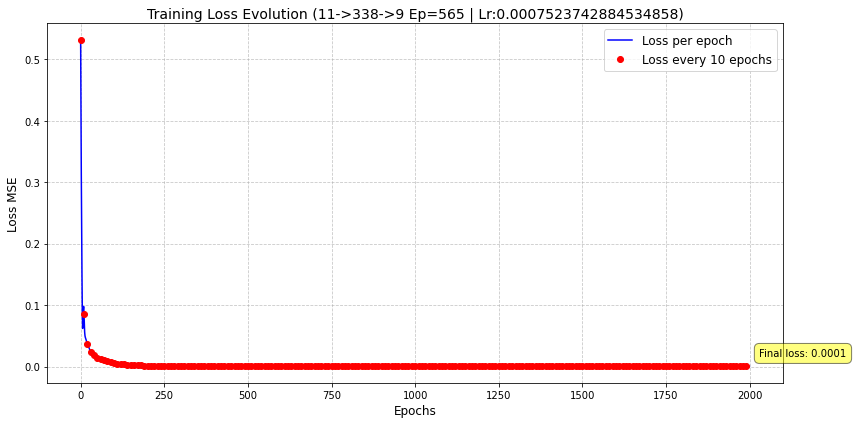

In [68]:
import matplotlib.pyplot as plt

# Create the loss plot with better formatting
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_values, 'b-', label='Loss per epoch')
plt.plot(epochs[::10], loss_values[::10], 'ro', label='Loss every 10 epochs')  # Pontos cada 10 épocas

plt.title('Training Loss Evolution '+ str_best_params, fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss '+loss_func, fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Add annotation with the final loss value
final_loss = loss_values[-1]
plt.annotate(f'Final loss: {final_loss:.4f}', 
             xy=(epochs[-1], loss_values[-1]),
             xytext=(10, 10), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

plt.tight_layout()
plt.show()

# Reading the Embedding

In [69]:
# Load your embeddings CSV

emb_df = pd.read_csv(f"{output_folder}/{name_file_emb}")
emb_df

,0,1,2,3,4,5,6,7,8
0,0.418257,-0.463474,-0.464447,-0.783122,-0.868691,-0.473914,0.441379,0.493269,0.390274
1,0.619088,-0.359816,-0.284881,-0.633024,-0.879334,-0.317535,0.447734,0.549174,0.587168
2,0.587328,-0.437012,-0.419924,-0.758469,-0.863517,-0.447545,0.242311,0.583694,0.478925
3,0.435722,-0.195764,-0.358078,-0.585446,-0.818931,-0.479882,0.298477,0.649634,0.656337
4,0.314251,-0.246020,-0.451279,-0.385117,-0.830632,-0.456087,0.347407,0.417100,0.776525
...,...,...,...,...,...,...,...,...,...
14635,0.202435,-0.061688,-0.758308,-0.178173,-1.191207,0.159116,0.461193,0.633995,-0.050331
14636,0.272011,-0.018086,-0.261586,-0.560184,-0.787546,-0.428598,0.341080,0.336197,0.467340
14637,0.266388,-0.148303,-0.502745,-0.710671,-0.920540,-0.226178,0.348508,0.692883,0.882212
14638,0.158527,0.065152,-1.021695,-0.082047,-1.116920,0.080214,0.437894,0.656480,0.199723


### TSNE

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# import umap.umap_ as umap

print('data_set' ,data_set)

perplexity = 50

# Drop non-numeric columns (e.g., node IDs or labels if present)
numeric_cols = emb_df.select_dtypes(include=[np.number]).columns
emb_df = emb_df[numeric_cols]

# t-SNE
# tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
tsne = TSNE(
        n_components=2,
        perplexity=perplexity,             # más alto para datos grandes
#         n_iter=1500,               # más iteraciones
        learning_rate=300,         # o prueba n_samples/12 = 89240/12 ≈ 7437
        method='barnes_hut',       # eficiente para 2D
        random_state=42,
        verbose=1
    )


data_set real


In [73]:
tsne_result = tsne.fit_transform(emb_df)

tsne_df = pd.DataFrame(tsne_result)

tsne_df.to_csv(f"{output_folder}/tsne_output_{TYPE_DATA}_{suffix}.csv", index=False)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 14640 samples in 0.059s...
[t-SNE] Computed neighbors for 14640 samples in 3.957s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14640
[t-SNE] Computed conditional probabilities for sample 2000 / 14640
[t-SNE] Computed conditional probabilities for sample 3000 / 14640
[t-SNE] Computed conditional probabilities for sample 4000 / 14640
[t-SNE] Computed conditional probabilities for sample 5000 / 14640
[t-SNE] Computed conditional probabilities for sample 6000 / 14640
[t-SNE] Computed conditional probabilities for sample 7000 / 14640
[t-SNE] Computed conditional probabilities for sample 8000 / 14640
[t-SNE] Computed conditional probabilities for sample 9000 / 14640
[t-SNE] Computed conditional probabilities for sample 10000 / 14640
[t-SNE] Computed conditional probabilities for sample 11000 / 14640
[t-SNE] Computed conditional probabilities for sample 12000 / 14640
[t-SNE] Computed conditional probabilities for sa

### Coloring tsne output using original cluster IDs

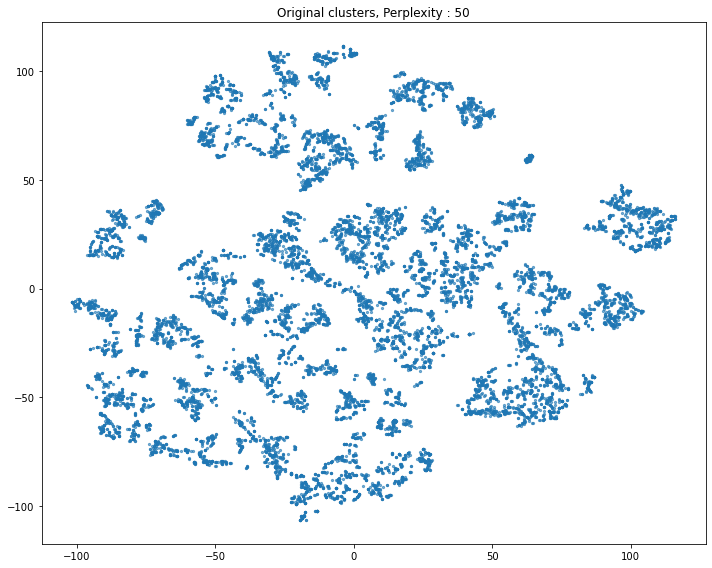

In [74]:
import matplotlib.colors as mcolors

# # Visualization
plt.figure(figsize=(10, 8))
cmap = mcolors.ListedColormap(plt.cm.tab20.colors[8:])
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], 
                      alpha=0.6, s = 5)
# plt.colorbar(scatter, label='Cluster ID')
plt.title(f'Original clusters, Perplexity : {perplexity}')
plt.tight_layout()
plt.savefig(f'{output_folder}/tsne_original_Ids_{TYPE_DATA}_{data_set}_{type_graph_conv}.png', dpi=300) 
plt.show()

## Apply Kmeans on Embeddings

In [76]:
from sklearn.cluster import KMeans

n_clusters = 12

# train K-means 
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(emb_df)

In [77]:
# add Kmeans cluster IDs
df_nodes['clusterID_kmeans_'+TYPE_DATA] = clusters


In [78]:
df_nodes

,Nodo,2006.01,2006.02,2006.03,2006.04,2006.05,2006.06,2006.07,2006.08,2006.09,...,18_a_65_anos_taxa,maiores_de_65_anos_taxa,Pontos_de_onibus,Estacao_de_metro,Estacao_de_trem,Terminal_de_onibus,Favela_proxima,lat,long,clusterID_kmeans_S
0,573641,1,0,0,0,0,0,0,0,0,...,0.631893,0.157168,0.0,1.0,3.0,1.0,0.0,-23.562991,-46.703965,7
1,573643,0,0,0,0,0,0,1,0,1,...,0.648065,0.182571,0.0,3.0,3.0,1.0,0.0,-23.567465,-46.702229,2
2,573644,0,1,0,1,1,0,0,0,0,...,0.742215,0.132719,0.0,3.0,3.0,1.0,0.0,-23.572962,-46.699235,2
3,582438,0,0,0,1,0,0,0,2,0,...,0.723529,0.151361,0.0,2.0,2.0,3.0,0.0,-23.528187,-46.661920,6
4,582442,0,0,0,0,0,0,0,0,0,...,0.691275,0.161074,0.0,0.0,2.0,4.0,0.0,-23.517308,-46.656944,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,25798409,0,0,0,0,0,0,0,0,0,...,0.652312,0.081330,0.0,0.0,4.0,2.0,1.0,-23.507885,-46.712039,9
14636,25870742,0,0,0,0,0,0,0,0,0,...,0.676118,0.092597,0.0,0.0,1.0,2.0,0.0,-23.563471,-46.611300,0
14637,25871831,0,0,0,0,0,0,0,0,0,...,0.686654,0.092843,0.0,3.0,4.0,5.0,0.0,-23.551894,-46.625727,5
14638,25875949,0,0,0,0,0,0,0,0,0,...,0.672624,0.097612,0.0,1.0,3.0,5.0,1.0,-23.521011,-46.637123,9


### Coloring tsne output using Kmeans cluster IDs

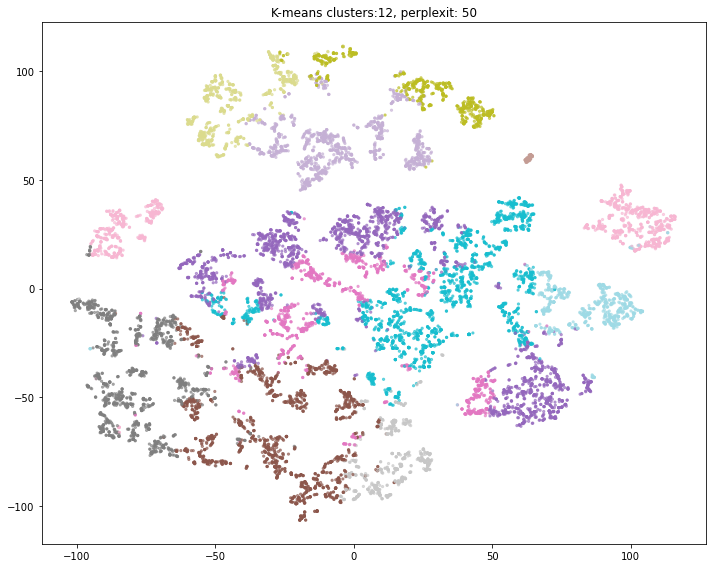

In [79]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], 
                     c=df_nodes['clusterID_kmeans_'+TYPE_DATA], cmap=cmap, alpha=0.6, s = 5)

plt.title(f'K-means clusters:{n_clusters}, perplexit: {perplexity}')
plt.tight_layout()
plt.savefig(f'{output_folder}/tsne_kmeans_Ids_{TYPE_DATA}_{data_set}_{type_graph_conv}.png', dpi=300) 
plt.show()

In [80]:
# Seleccionar las columnas
columns_to_save = ['Nodo', f'clusterID_kmeans_{TYPE_DATA}']
df_selected = df_nodes[columns_to_save]

# Crear nombre de archivo
filename = f'to_dissim_clusterID_kmeans_{TYPE_DATA}_{data_set}_{type_graph_conv}.csv'

# Guardar como CSV
df_selected.to_csv(f"{output_folder}/{filename}", index=False)

print(f'Archivo guardado como: {filename}')


Archivo guardado como: to_dissim_clusterID_kmeans_S_real_SAGE.csv


## Locating clusters using kmeans cluster_ids

#### normalize dynamic and static on same scale

In [91]:
from datetime import datetime
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist, pdist
from itertools import combinations
from fastdtw import fastdtw
from multiprocessing import Pool, cpu_count

# # Data type configuration
data_type = "dynamic"   # "or dynamic" # Choose dynamic for cross clustering


# Create filename
filepath = f'{output_folder}/{filename}'
print(filepath)

# Open file with columns [Nodo,clusterID_kmeans_] 
df_clusters = pd.read_csv(filepath)
name_column = 'clusterID_kmeans_'+TYPE_DATA

if data_type == "static":
    df_features_clusters = pd.concat([static_dt_norm, df_clusters], axis = 1)
else:
    df_features_clusters = pd.concat([dynamic_dt_norm, df_clusters], axis = 1)


# Removing 'Nodo' column
df_features_clusters = df_features_clusters.drop(columns=['Nodo'])

# Group the DataFrame by 'clusterID' and convert each group to a list
listas_por_cluster = [group.drop(name_column, axis=1).values.tolist() for _, group in df_features_clusters.groupby(name_column)]


real/SAGE_25_june_exp_smooth_static/to_dissim_clusterID_kmeans_S_real_SAGE.csv


# Calculation of distances

In [92]:
df_features_clusters

,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,clusterID_kmeans_S
0,0.0,0.002336,0.002325,0.002313,0.002302,0.002290,0.002279,0.002267,0.002256,0.002245,...,0.110577,0.110084,0.109594,0.109105,0.108618,0.108133,0.107650,0.107169,0.106689,7
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002336,0.002325,0.004638,...,0.073638,0.073298,0.072958,0.072620,0.072284,0.071949,0.073621,0.073280,0.072941,2
2,0.0,0.000000,0.002336,0.002325,0.004638,0.006928,0.006894,0.006860,0.006826,0.006792,...,0.145027,0.146120,0.145492,0.144867,0.144243,0.145343,0.144717,0.144094,0.145195,2
3,0.0,0.000000,0.000000,0.000000,0.002336,0.002325,0.002313,0.002302,0.006929,0.006894,...,0.091716,0.095139,0.096618,0.096181,0.095746,0.099119,0.098672,0.100123,0.109044,6
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.008422,0.008380,0.008339,0.008298,0.008256,0.008215,0.008175,0.008134,0.008094,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9
14636,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
14637,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5
14638,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9


In [93]:

# ===================
# subsampling at 10%
# # ===================

import random
sub_listas_por_cluster = []
max_samples = 200  # set your maximum threshold here

for lista in listas_por_cluster:
    n = len(lista)
    muestra_size = min(max_samples, max(1, int(0.05 * n)))  # limit the sample size
    muestra = random.sample(lista, muestra_size) if n >= muestra_size else lista.copy()
    sub_listas_por_cluster.append(muestra)

for idx, sublista in enumerate(sub_listas_por_cluster):
    print(f"Cluster {idx}: {len(sublista)} samples")

# ===================
# DISTANCE FUNCTIONS
# ===================
def average_intra_cluster_distance(X_cluster, data_type='static'):
    n = len(X_cluster)
    if n <= 1:
        return 0.0
    if data_type == 'static':
        return np.mean(pdist(X_cluster, 'euclidean'))
    elif data_type == 'dynamic':
        distances = []
        for i in range(n):
            for j in range(i + 1, n):
                dist, _ = fastdtw(X_cluster[i], X_cluster[j])
                distances.append(dist)
        return np.mean(distances)
    else:
        raise ValueError("data_type must be either 'static' or 'dynamic'")

def minimum_inter_cluster_distance(X_cluster_i, X_cluster_j, data_type='static'):
    if len(X_cluster_i) == 0 or len(X_cluster_j) == 0:
        return np.inf
    if data_type == 'static':
        dist_matrix = cdist(X_cluster_i, X_cluster_j, 'euclidean')
    elif data_type == 'dynamic':
        dist_matrix = np.zeros((len(X_cluster_i), len(X_cluster_j)))
        for i in range(len(X_cluster_i)):
            for j in range(len(X_cluster_j)):
                dist, _ = fastdtw(X_cluster_i[i], X_cluster_j[j])
                dist_matrix[i, j] = dist
    else:
        raise ValueError("data_type must be either 'static' or 'dynamic'")
    return np.min(dist_matrix)

def compute_cluster_dissimilarity2(a_i, a_j, b_ij):
    denom1 = np.maximum(a_i, b_ij)
    term1 = np.divide(b_ij - a_i, denom1, out=np.zeros_like(np.array([b_ij])), where=(denom1 != 0))
    denom2 = np.maximum(a_j, b_ij)
    term2 = np.divide(b_ij - a_j, denom2, out=np.zeros_like(np.array([b_ij])), where=(denom2 != 0))
    return 0.5 * (term1 + term2)

def compute_pair_dissimilarity(args):
    i, j, clusters, data_type = args
    a_i = average_intra_cluster_distance(clusters[i], data_type)
    a_j = average_intra_cluster_distance(clusters[j], data_type)
    b_ij = minimum_inter_cluster_distance(clusters[i], clusters[j], data_type)
    S_ij = compute_cluster_dissimilarity2(a_i, a_j, b_ij)
    return (i, j, S_ij)

def compute_all_cluster_dissimilarities(clusters, data_type='static'):
    n = len(clusters)
    S = np.zeros((n, n))

    args_list = [(i, j, clusters, data_type) for i, j in combinations(range(n), 2)]

    with Pool(processes=cpu_count()) as pool:
        results = pool.map(compute_pair_dissimilarity, args_list)

    for i, j, S_ij in results:
        S[i, j] = S[j, i] = S_ij

    print("Matriz de disimilitudes:\n", S)
    return S

# ===================
# Execution
# ===================

time_start = datetime.now()
print('time_start', time_start.strftime("%H:%M:%S"), 'para', data_type)

if data_type == "static":
    D = compute_all_cluster_dissimilarities(listas_por_cluster, data_type=data_type)
else: # cross clustering option
    D = compute_all_cluster_dissimilarities(sub_listas_por_cluster, data_type=data_type)
    
time_end = datetime.now()
print(time_start.strftime("%H:%M:%S"), '-', time_end.strftime("%H:%M:%S"))

elapsed_time = (time_end - time_start).total_seconds()
print('Elapsed time:', str(elapsed_time), 'seconds')


Cluster 0: 128 samples
Cluster 1: 65 samples
Cluster 2: 91 samples
Cluster 3: 3 samples
Cluster 4: 59 samples
Cluster 5: 57 samples
Cluster 6: 70 samples
Cluster 7: 32 samples
Cluster 8: 34 samples
Cluster 9: 39 samples
Cluster 10: 115 samples
Cluster 11: 35 samples
time_start 10:13:54 para dynamic
Matriz de disimilitudes:
 [[ 0.         -1.         -1.         -0.96364968 -1.         -1.
  -0.999996   -1.         -0.99991346 -0.99999617 -1.         -0.99999625]
 [-1.          0.         -0.99998472 -0.90314584 -0.99998609 -0.99999502
  -0.99997042 -0.99999249 -0.99999075 -0.99999315 -0.99999498 -0.99996683]
 [-1.         -0.99998472  0.         -0.95968431 -1.         -0.99999677
  -0.99999603 -0.99999276 -0.99997579 -0.99996725 -1.         -0.99990167]
 [-0.96364968 -0.90314584 -0.95968431  0.         -0.82170676 -0.97361506
  -0.94198244 -0.90095456 -0.89146626 -0.93575162 -0.96837063 -0.96170578]
 [-1.         -0.99998609 -1.         -0.82170676  0.         -1.
  -1.         -1.   

In [94]:
df = pd.DataFrame(D)
df.to_csv(f'{output_folder}/cluster_dissimilarities_matrix_{TYPE_DATA}_{data_set}_{data_type}_{type_graph_conv}.csv', index=False)

print(f'Final result: cluster_dissimilarities_matrix_{TYPE_DATA}_{data_set}_v1_clusterID_D_in_{data_type}_{type_graph_conv}.csv')

Final result: cluster_dissimilarities_matrix_S_real_v1_clusterID_D_in_dynamic_SAGE.csv
